In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
#         print(os.path.join(dirname, filename))
        pass

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

!pip install fastai

In [2]:
from fastai.vision.all import *
from scipy.ndimage import zoom
import torch.nn.functional as F

# Define the path
path = Path('/kaggle/input/cell-images-for-detecting-malaria/cell_images/')

In [3]:
# Check if files are imported, Should show Parasitized and Uninfectted folders
!ls /kaggle/input/cell-images-for-detecting-malaria/cell_images/cell_images

Parasitized  Uninfected


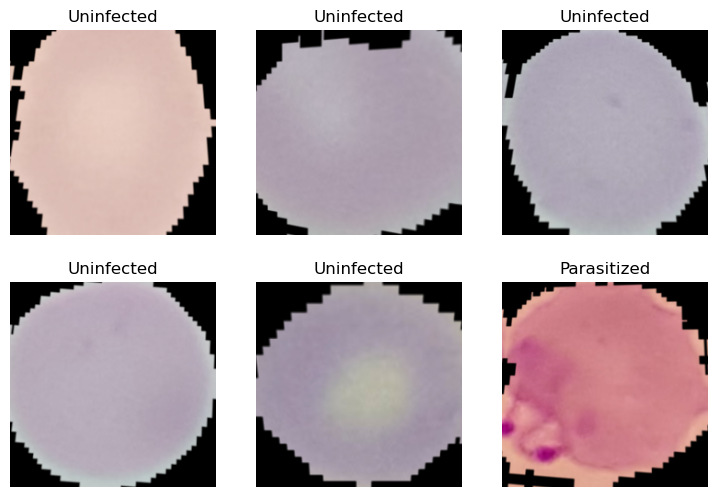

In [4]:
# Create Datablock
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=0),
    get_y=parent_label, 
    item_tfms=Resize(460), 
    batch_tfms=aug_transforms(size=224)
).dataloaders(path)

# Check if Images are Loaded
dls.show_batch(max_n=6)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 214MB/s]


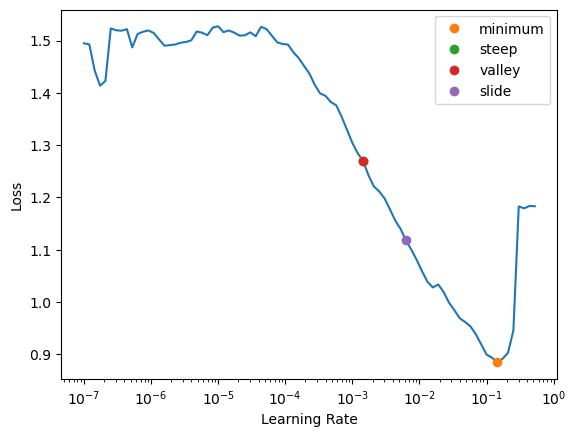

In [5]:
# Define the learner with a CNN (resnet34)
learn = vision_learner(dls, resnet34, metrics=accuracy)

# Find a good learning rate by Plotting Loss vs Learning Rate
# https://sgugger.github.io/how-do-you-find-a-good-learning-rate.html - for finding a good learning rate
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))


In [6]:
# Get learning rate with largest negative slope
lrs.valley

0.0014454397605732083

In [7]:
# Finetune Model using Learning Rate where learning rate gives steepest downards slope
learn.fine_tune(8, base_lr=lrs.valley)

epoch,train_loss,valid_loss,accuracy,time
0,0.207320,0.153151,0.950195,09:02


epoch,train_loss,valid_loss,accuracy,time
0,0.129860,0.105455,0.962624,06:44
1,0.113373,0.086489,0.969700,06:45
2,0.107831,0.079590,0.972512,06:45
3,0.082625,0.074561,0.976413,06:46
4,0.082542,0.063255,0.978499,06:44
5,0.055320,0.050631,0.982400,06:44
6,0.048064,0.044179,0.985666,06:59
7,0.038732,0.044288,0.986483,06:55


In [8]:
learn.save('MalariaCellProcessing')

Path('models/MalariaCellProcessing.pth')

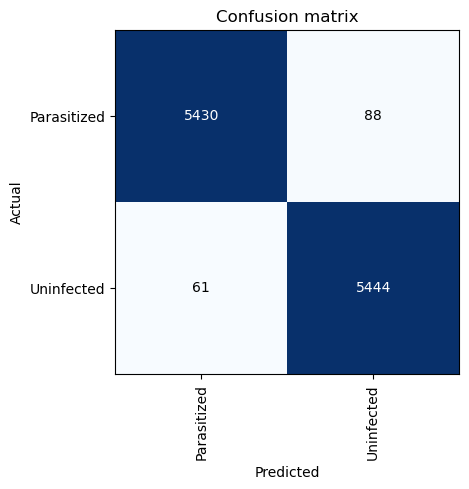

In [9]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

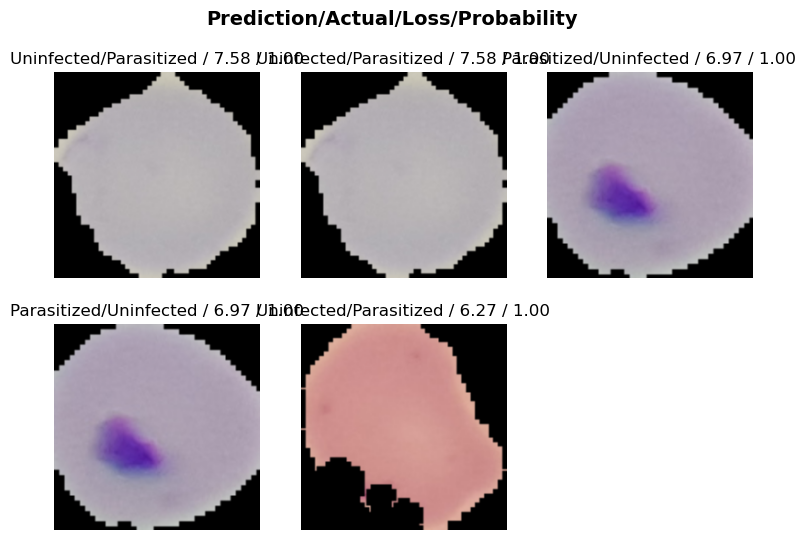

In [10]:
interp.plot_top_losses(5)


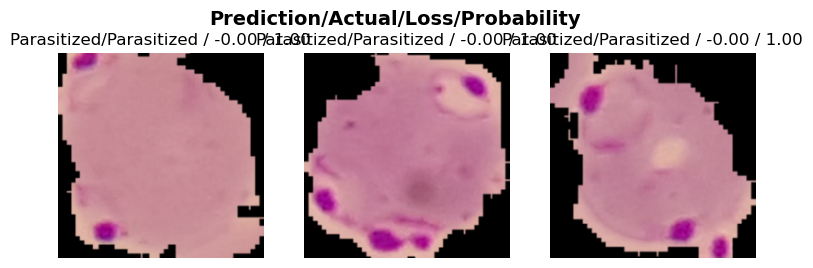

In [11]:
interp.plot_top_losses(3, largest=False)

In [12]:
# Get the indices of the items with the highest losses
top_losses = interp.top_losses(3)
# Get the indices of the items with the smallest losses
smallest_losses = interp.top_losses(3, largest=False)

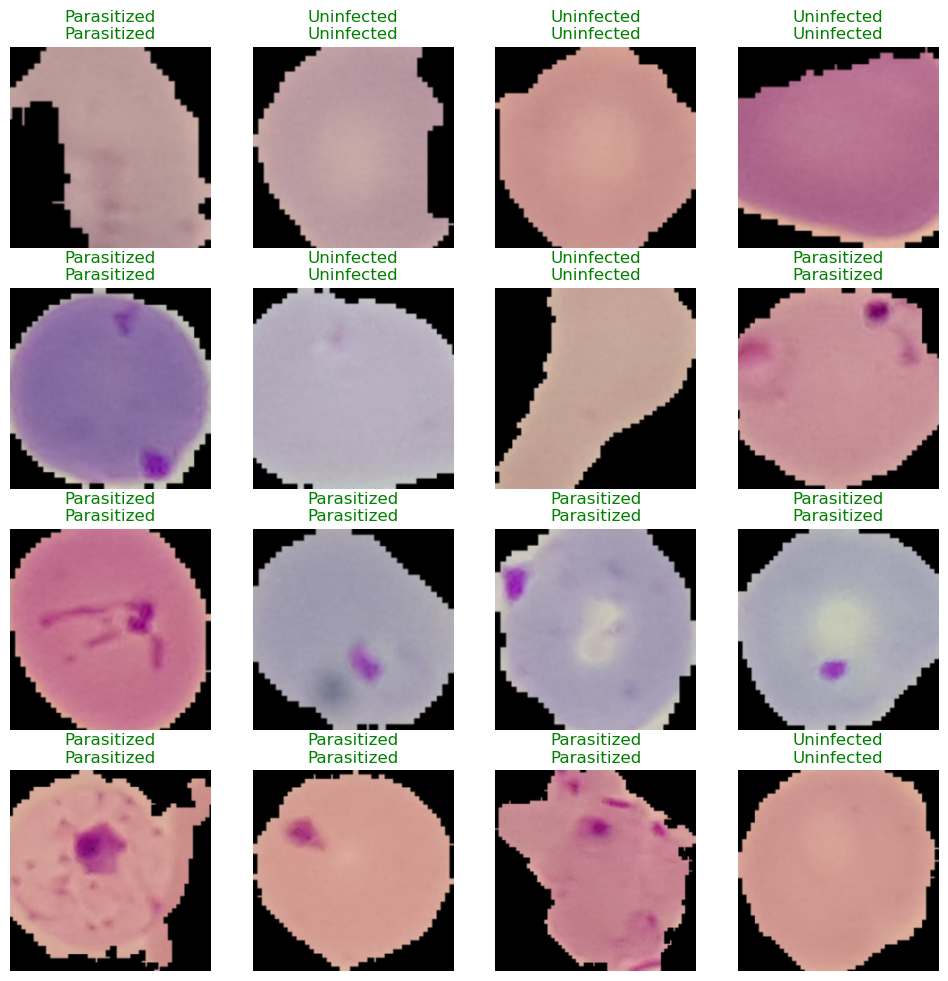

In [13]:
learn.show_results(max_n=16)

In [14]:
import matplotlib.pyplot as plt
from torch.nn.functional import softmax

class Hook():
    def __init__(self, m):
        self.hook = m.register_forward_hook(self.hook_func)
    def hook_func(self, m, i, o): self.stored = o.detach().clone()
    def __enter__(self, *args): return self
    def __exit__(self, *args): self.hook.remove()

class HookBwd():
    def __init__(self, m):
        self.hook = m.register_backward_hook(self.hook_func)
    def hook_func(self, m, gi, go): self.stored = go[0].detach().clone()
    def __enter__(self, *args): return self
    def __exit__(self, *args): self.hook.remove()

In [15]:
def plot_grad_cam(learn, data, losses_indices):
    for loss, idx in zip(losses_indices[0], losses_indices[1]):
        # Get the image
        img = data.valid_ds[idx][0]
        x, = first(data.test_dl([img]))
        
        cls = 1  
        with HookBwd(learn.model[0]) as hookg:
            with Hook(learn.model[0]) as hook:
                output = learn.model.eval()(x.cuda())
                act = hook.stored
            output[0, cls].backward()
            grad = hookg.stored

        # Compute the Grad-CAM map
        w = grad[0].mean(dim=[1,2], keepdim=True)
        cam_map = (w * act[0]).sum(0)

        # Plot the original image and the Grad-CAM heatmap
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        x_dec = TensorImage(data.train.decode((x,))[0][0])

        # Plot original image
        x_dec.show(ctx=ax1)
        ax1.set_title("Original Image")
        ax1.axis('off')

        # Plot Grad-CAM heatmap
        ax2.imshow(cam_map.detach().cpu(), alpha=0.6, extent=(0,224,224,0),
                  interpolation='bilinear', cmap='magma')
        ax2.axis('off')

        # Plot original image with Grad-CAM heatmap overlay
        ax2.imshow(x_dec.permute(1, 2, 0), alpha=0.4)
        ax2.set_title(f"Overlay Image with Grad-CAM\n Loss: {loss.item()}")

        plt.show()


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1344: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


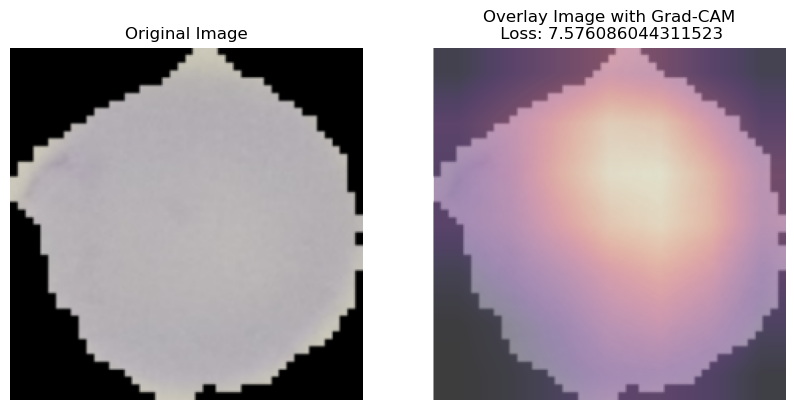

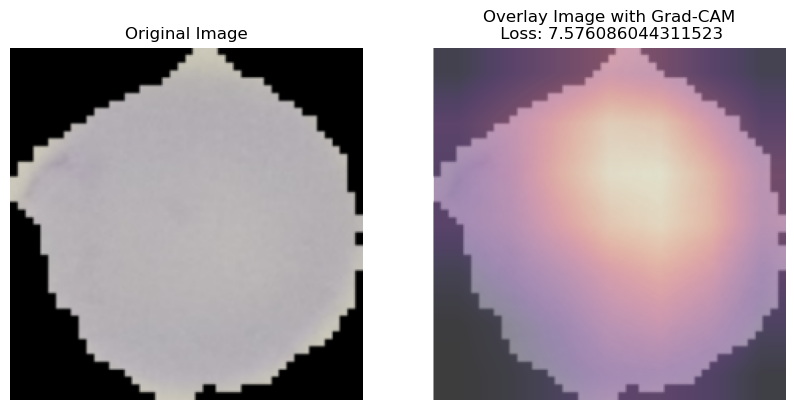

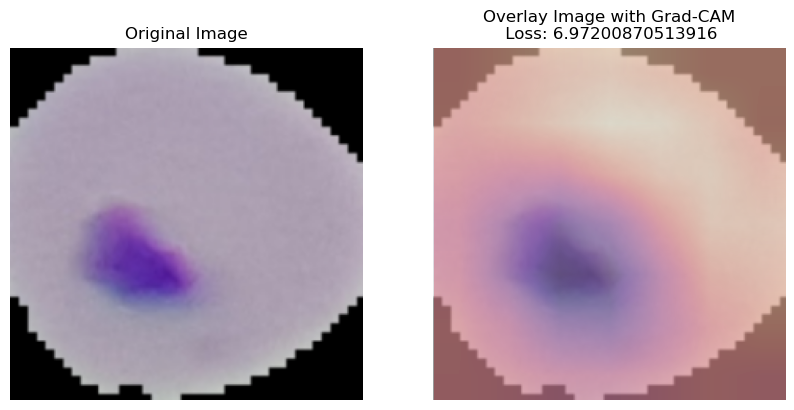

In [16]:
plot_grad_cam(learn, dls, top_losses)

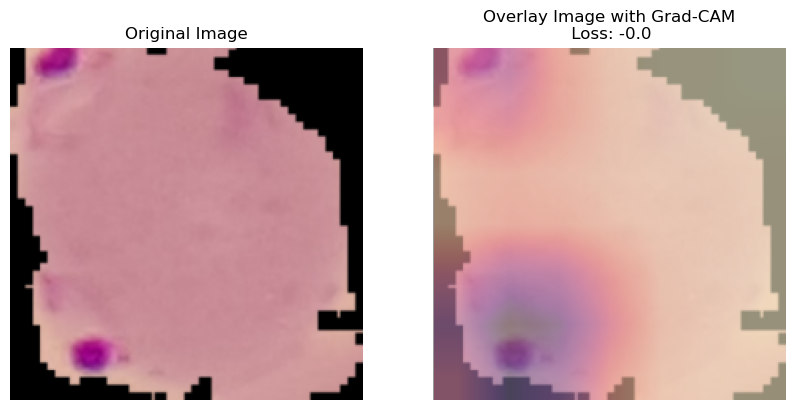

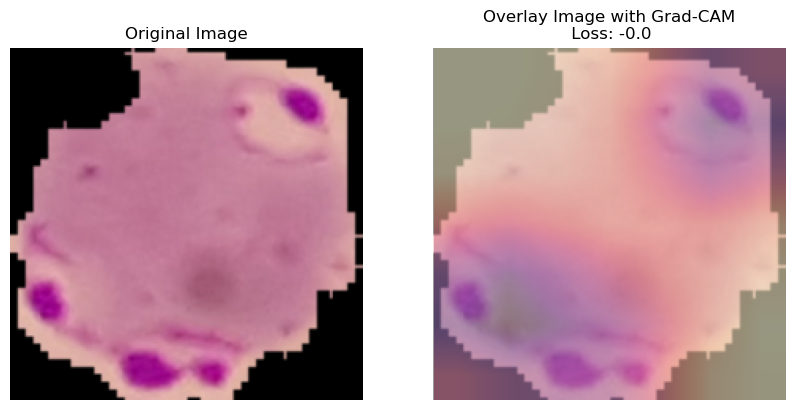

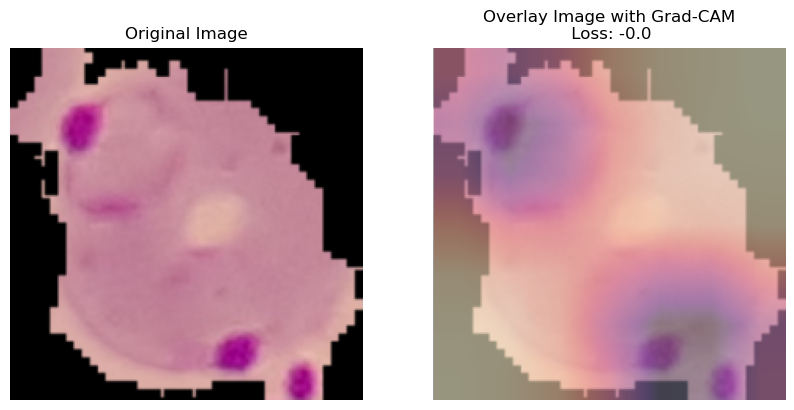

In [17]:
plot_grad_cam(learn, dls, smallest_losses)